# Knowledge Informed Machine Learning using a Weibull-based Loss Function
> Exploring the concept of knowledge-informed machine learning with the use of a Weibull-based loss function. Used to predict remaining useful life (RUL) on the [IMS](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#bearing) and [PRONOSTIA](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#femto) (also called FEMTO) bearing data sets.

This notebook reproduces the results from the paper "Knowledge Informed Machine Learning using a Weibull-based Loss Function". The notebook also provides additional data exploration and explanation of the code used in the experiments.

**Note:** You can replicate the results without having to download the data in Section 1. Section 1 is only needed for the data exploration.

If you have any questions, feel free to reach out or leave a question in the [discussions](https://github.com/tvhahn/weibull-knowledge-informed/discussions).

## Table of Contents
* [1. Download Data (colab)](#1.-Download-Data-(colab)) - download the data sets and extract them to the colab environment
* [2. Explore Data](#2.-Explore-Data) - see how the data looks

First, import the required packages.

In [33]:
import numpy as np
from pathlib import Path
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal, fftpack
import time
import datetime
import h5py

from src.features.build_features import create_fft, build_spectrogram_df_ims, build_spectrogram_df_femto
from src.visualization.visualize_data import create_time_frequency_plot, plot_freq_peaks
from src.data.data_utils import create_date_dict


from IPython.display import clear_output, display # clear the output if needed
import warnings
warnings.filterwarnings("ignore") # supress all the matplotlib deprecation warnings

# 1. Download Data (colab)

In [ ]:
!git clone https://github.com/tvhahn/weibull-knowledge-informed.git

# move into EarthGAN folder
%cd weibull-knowledge-informed

# make editable
!pip install -e .

Download the IMS and PRONOSTIA (FEMTO) bearing data sets from the NASA Prognostics Repository.

In [ ]:
!bash /content/weibull-knowledge-informed/src/data/download_data_local.sh /content/weibull-knowledge-informed

Extract the downloaded data. You will have to answer several prompts to replace folders. **Answer [A]ll.**

(note: will take several minutes to extract)

In [ ]:
!bash /content/weibull-knowledge-informed/src/data/extract_data_local.sh /content/weibull-knowledge-informed

Now we will create the train/val/test data sets used to train the models.

In [ ]:
# !python /content/weibull-knowledge-informed/src/data/make_dataset.py data/raw data/processed

And train some models as an example (we'll use the IMS data set).

In [ ]:
# !python /content/weibull-knowledge-informed/src/models/train_models.py \
# --data_set ims \
# --path_data data/processed \
# --proj_dir /content/weibull-knowledge-informed/

# 2. Explore Data
Let's start with the IMS data first.

In [2]:
# set the root (parent folder) and the data folder locations
folder_root = Path.cwd() # get root folder of repository

folder_raw_data = folder_root / 'data/raw/IMS/' # raw data folder

In [3]:
# load text file for first measurement
# first test folder location
folder_1st = folder_raw_data / '1st_test'

# can use numpy...
d = np.loadtxt(folder_1st / '2003.10.22.12.06.24')

# let's use pandas
    # b1_ch1 - Bearing 1, channel 1
    # b1_ch2 - Bearing 1, channel 2
    # etc, etc ...

col_names = ['b1_ch1', 'b1_ch2', 'b2_ch3', 'b2_ch4', 'b3_ch5', 'b3_ch6', 'b4_ch7', 'b4_ch8']
df = pd.read_csv(folder_1st / '2003.10.22.12.06.24', sep='\t', names=col_names)
df.head()

,b1_ch1,b1_ch2,b2_ch3,b2_ch4,b3_ch5,b3_ch6,b4_ch7,b4_ch8
0,-0.022,-0.039,-0.183,-0.054,-0.105,-0.134,-0.129,-0.142
1,-0.105,-0.017,-0.164,-0.183,-0.049,0.029,-0.115,-0.122
2,-0.183,-0.098,-0.195,-0.125,-0.005,-0.007,-0.171,-0.071
3,-0.178,-0.161,-0.159,-0.178,-0.100,-0.115,-0.112,-0.078
4,-0.208,-0.129,-0.261,-0.098,-0.151,-0.205,-0.063,-0.066


In [4]:
# what is the shape of the dataframe?
df.shape

(20480, 8)

Gousseau et al. postulate in their paper ['Analysis of the Rolling Element Bearing data set of the Center for Intelligent Maintenance Systems of theUniversity of Cincinnati'](https://hal.archives-ouvertes.fr/hal-01715193) that the actual collection frequency is 20.48 kHz.

We will use this collection frequency.

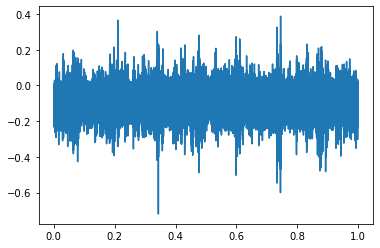

In [5]:
# plot first bearing channel
fig, ax = plt.subplots()

ax.plot(
    np.arange(0,df.shape[0], dtype='float64') / (20.48 * 10**3), # make x-axis in seconds
    df['b1_ch1'] # acceleration data
)

We will want to "detrend" and window the signal -- this is a basic signal processing step.

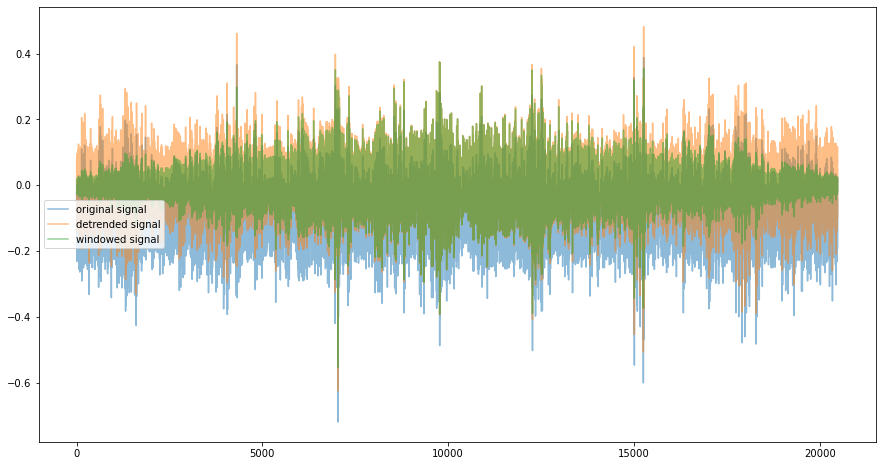

In [6]:
# practice detrending
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

plt.plot(df['b1_ch1'], alpha=0.5, label='original signal')
y_detrend = signal.detrend(df['b1_ch1'], type="linear")
plt.plot(y_detrend, alpha=0.5, label='detrended signal')

# apply either a hamming or kaiser windowing function
# y_detrend *= np.hamming(len(y_detrend))
y_detrend *= np.kaiser(len(y_detrend), 3)
plt.plot(y_detrend, alpha=0.5, label='windowed signal')
plt.legend(loc='center left')

Use a function to create the FFT (`create_fft`), and another function to plot the time and frequency domains (`create_time_frequency_plot`).

Import those functions first.

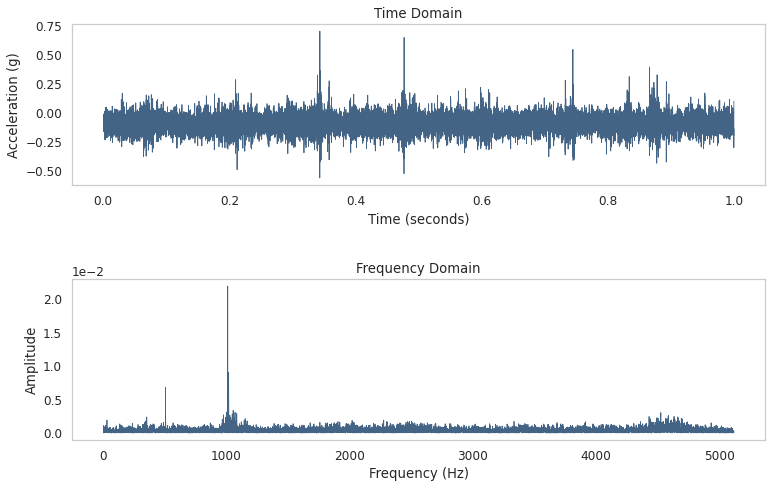

In [7]:
# create fft
x, y, xf, yf = create_fft(df, y_name='b1_ch2', sample_freq=20480.0, window='kaiser', beta=3)

# plot
create_time_frequency_plot(x, y, xf, yf, save_plot=False)

It is interesting to look at the peaks in the frequency domain plot, since different peaks can correspond to different parts of the bearing.example.ipynb

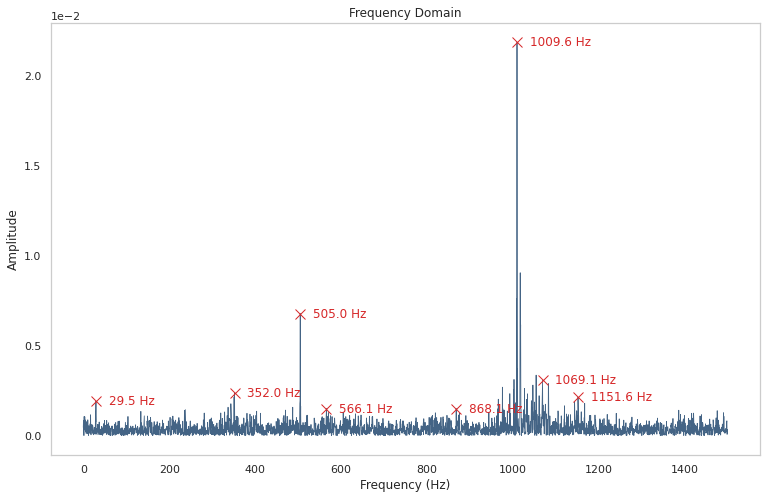

In [8]:
# only plot to 1500 Hz
plot_freq_peaks(xf, yf, max_freq_to_plot=1500, peak_height=0.0015, peak_distance=50)

## 2.1 Build Spectrograms - IMS
We will create a spectrogram of each run. A spectrogram is merely a "stack" of FFTs over time.

We have created a function, `build_spectrogram_df_ims`, that creates the spectrogram.

In [21]:
folder_2nd = folder_raw_data / '2nd_test'
date_list = sorted(os.listdir(folder_2nd))
col_names = ['b1_ch1', 'b2_ch2', 'b3_ch3', 'b4_ch4']
df_spec, labels_dict = build_spectrogram_df_ims(folder_2nd, date_list, channel_name='b1_ch1', start_time=date_list[0], col_names=col_names)

The output from the `build_spectrogram_df_ims` is a dataframe of the spectrogram, and a dictionary of the times when the signals were collected. Here's what the dataframe looks like:

In [22]:
df_spec.head()

,2004-02-12 10:32:39,2004-02-12 10:42:39,2004-02-12 10:52:39,2004-02-12 11:02:39,2004-02-12 11:12:39,2004-02-12 11:22:39,2004-02-12 11:32:39,2004-02-12 11:42:39,2004-02-12 11:52:39,2004-02-12 12:02:39,...,2004-02-19 04:52:39,2004-02-19 05:02:39,2004-02-19 05:12:39,2004-02-19 05:22:39,2004-02-19 05:32:39,2004-02-19 05:42:39,2004-02-19 05:52:39,2004-02-19 06:02:39,2004-02-19 06:12:39,2004-02-19 06:22:39
0.000000,0.000024,0.000141,0.000061,0.000151,0.000162,0.000109,0.000011,0.000224,0.000063,0.000124,...,0.000134,0.000621,0.000954,0.001193,0.000042,0.004888,0.001586,0.002111,1.313696e-05,4.002598e-07
0.500049,0.000108,0.000331,0.000160,0.000427,0.000230,0.000141,0.000141,0.000155,0.000010,0.000209,...,0.000166,0.001105,0.000621,0.002353,0.000079,0.009494,0.001793,0.004486,2.244507e-05,2.396428e-06
1.000098,0.000050,0.000463,0.000212,0.000369,0.000105,0.000053,0.000775,0.000103,0.000157,0.000238,...,0.002195,0.001729,0.003201,0.000662,0.001653,0.008596,0.000992,0.002695,1.258018e-04,1.053962e-04
1.500146,0.000076,0.000226,0.000009,0.000635,0.000055,0.000339,0.000335,0.000292,0.000147,0.000021,...,0.000690,0.006195,0.003012,0.000025,0.000454,0.001320,0.001346,0.003556,5.684309e-06,4.417664e-07
2.000195,0.000598,0.000471,0.000539,0.000234,0.000268,0.000072,0.000052,0.000369,0.000300,0.000125,...,0.002162,0.001502,0.004441,0.000352,0.000876,0.000680,0.002292,0.000200,3.039638e-07,4.935681e-06


Here is a value from the `labels_dict2`, generated from the above function. Each key in the dictionary represents a list that holds five time values/formats.

* Date with a nice format, like `2004-02-12 10:32:39`
* Date with underscores, like `2004_02_12_10_32_39` - this is also the key for this dictionary item.
* Unix timestamp, like `1076610759.0`
* Time increment since start of run (in seconds), like `18000.0`
* Time increment since start of run (in days), like `0.20833333333333334`

In [23]:
labels_dict['2004_02_12_15_32_39']

['2004-02-12 15:32:39',
 '2004_02_12_15_32_39',
 1076628759.0,
 18000.0,
 0.20833333333333334]

Let's plot the spectrogram.

The spectrogram is fairly "dim" unless you add a "vmax" value. This is partly because the 1000 Hz peak is dominating the FFT.

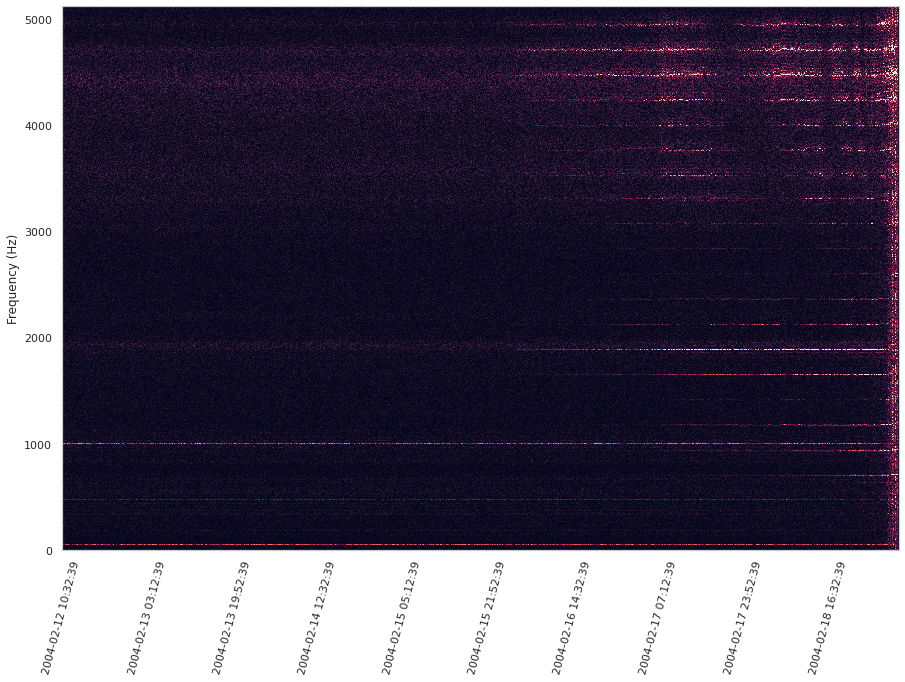

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

plt.pcolormesh(df_spec.columns, df_spec.index, df_spec, vmax=0.01) # need to add a vmax so that the color is not all dark

ax.set_ylabel("Frequency (Hz)")
plt.xticks(df_spec.columns[::100]) # show every 100th date on x-axis ticks
plt.xticks(rotation=75)

plt.show()

Try some other runs for the IMS data set and see what the spectrogram looks like!

In [25]:
folder_1st = folder_raw_data / "1st_test"

date_list1 = sorted(os.listdir(folder_1st))

col_names = [
    "b1_ch1",
    "b1_ch2",
    "b2_ch3",
    "b2_ch4",
    "b3_ch5",
    "b3_ch6",
    "b4_ch7",
    "b4_ch8",
]

df_spec1_3, labels_dict1_3 = build_spectrogram_df_ims(
    folder_1st,
    date_list1,
    channel_name="b3_ch5",
    start_time=date_list1[0],
    col_names=col_names,
)

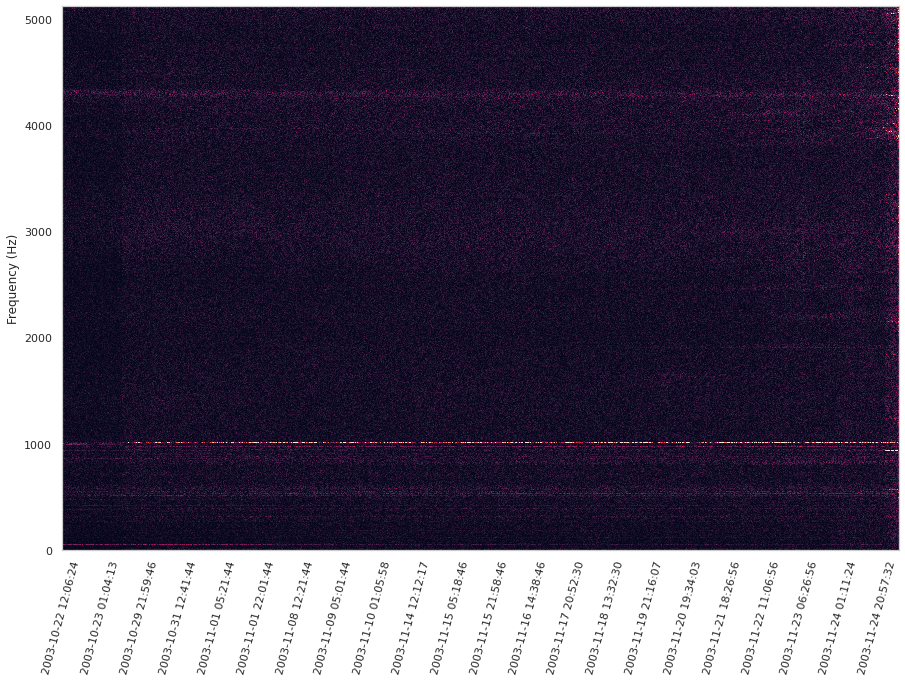

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

plt.pcolormesh(df_spec1_3.columns, df_spec1_3.index, df_spec1_3, vmax=0.01) # need to add a vmax so that the color is not all dark

ax.set_ylabel("Frequency (Hz)")
plt.xticks(df_spec1_3.columns[::100]) # show every 100th date on x-axis ticks
plt.xticks(rotation=75)

plt.show()

Inspect the `dataset_ims.py` (GitHub link [here](https://github.com/tvhahn/weibull-knowledge-informed/blob/master/src/data/dataset_ims.py)) to see how we create spectrograms for each of the three runs in the IMS data set.

## 2.2 Build Spectrograms - PRONOSTIA
Similarly, we can build spectrograms for the runs in the PRONOSTIA (FEMTO) bearing data set. Inspect the `dataset_femto.py` (GitHub link [here](https://github.com/tvhahn/weibull-knowledge-informed/blob/master/src/data/dataset_femto.py)) to see how we've created spectrograms for the runs in the data set.

In [35]:
folder_raw_data_train = (folder_root / 'data/raw' / "FEMTO/Learning_set/") 

folder_indv_bearing = folder_raw_data_train / "Bearing1_1"
date_dict = create_date_dict(folder_indv_bearing)
df_spec, labels_dict = build_spectrogram_df_femto(folder_indv_bearing, date_dict, channel_name="acc_horz",)

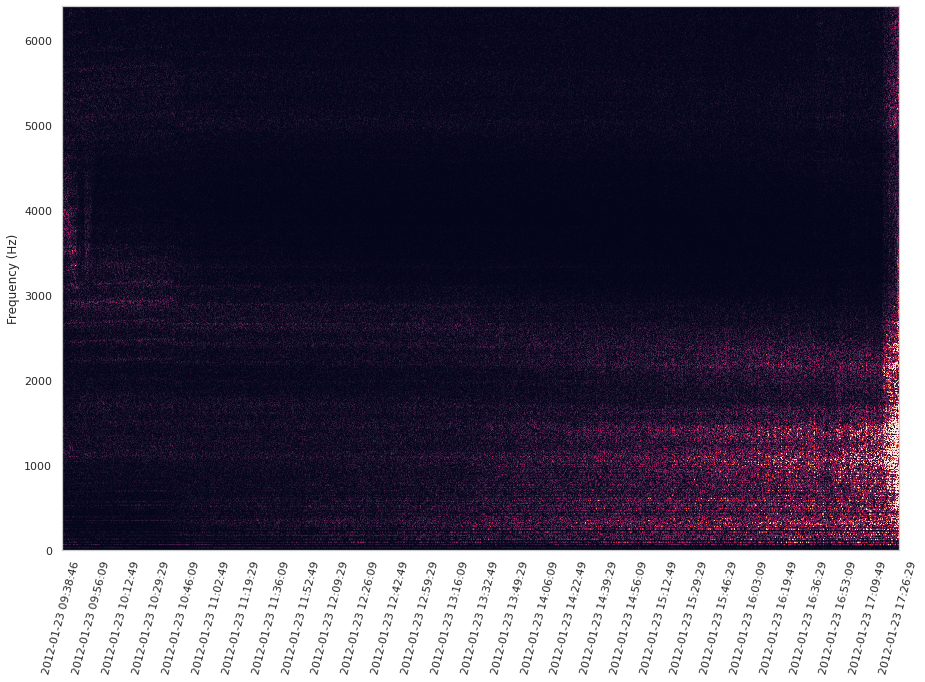

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

plt.pcolormesh(df_spec.columns, df_spec.index, df_spec, vmax=0.2) # need to add a vmax so that the color is not all dark

ax.set_ylabel("Frequency (Hz)")
plt.xticks(df_spec.columns[::100]) # show every 100th date on x-axis ticks
plt.xticks(rotation=75)

plt.show()